# Auto-Correlation


**Steps**:

1. Load CONUS dataset (5D, 14D temporal resolution)
2. Subset Area of Interest (AOI)
3. Interpolate the NANs
4. Smooth the Signal
5. Calculate the anomalies (remove the climatology)


## Package Preamble

In [1]:
import sys
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])


# append to path
sys.path.append(str(root))
sys.path.append("/home/emmanuel/code/isp_data")

# standard libraries
import geopandas as gpd
import xarray as xr
import numpy as np

xr.set_options(display_style="html")


# Helper Functions
from isp_data.drought.load import DroughtData
from isp_data.polygons import get_local_polygons
from isp_data.viz import plot_mean_time
from isp_data.esdc.subset import select_pixel
from isp_data.esdc.decomposition import calculate_monthly_mean

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='poster',font_scale=0.7)


%load_ext autoreload
%autoreload 2

## Preprocessing Steps

1. Load Drought Data
2. Select Area of Interest
3. Interpolate the NANs
4. Smooth the Signal
5. Remove Climatology

#### Helper Plot Functions

In [2]:
def plot_ts(ds):
    fig, ax = plt.subplots(nrows=4, figsize=(10,10))


    ds.to_dataframe()[["VOD"]].plot(ax=ax[0], color="Blue")
    ds.to_dataframe()[["LST"]].plot(ax=ax[1], color="Red")
    ds.to_dataframe()[["NDVI"]].plot(ax=ax[2], color="Green")
    ds.to_dataframe()[["SM"]].plot(ax=ax[3], color="Red")

    plt.tight_layout()
    plt.show()

In [3]:
# ============================
# 1 - Load Drought Data
# ============================
region = 'conus'
sampling = '5D'

drought_data = DroughtData()

drought_cube = drought_data.load_data(region, sampling)

# ============================
# 2 - Select Area of Interest
# ============================
pixel = (-121, 37)

demo_pixel = select_pixel(drought_cube, pixel, method='nearest')

# ======================
# 3 - Interpolate NANs
# ======================
# interpolation arguments
interp_dim = 'time'
method = 'slinear'

# do interpolation
demo_pixel_interp = demo_pixel.interpolate_na(
    dim=interp_dim, 
    method=method
)

# ======================
# 4 - Smooth Signal
# ======================
# smoothing parameters
window_length = 3
center = True

# apply savgol filter
demo_pixel_interp_rolling = demo_pixel_interp.rolling(
    time=window_length, 
    center=center, 
).mean()

# =======================
# 5 - Remove Climatology
# =======================
# calculate the climatology
demo_pixel_climatology_mean = calculate_monthly_mean(demo_pixel_interp_rolling)

# remove climatology
demo_pixel_anomalies = demo_pixel_interp_rolling.groupby('time.month') - demo_pixel_climatology_mean





#### Plot Signal

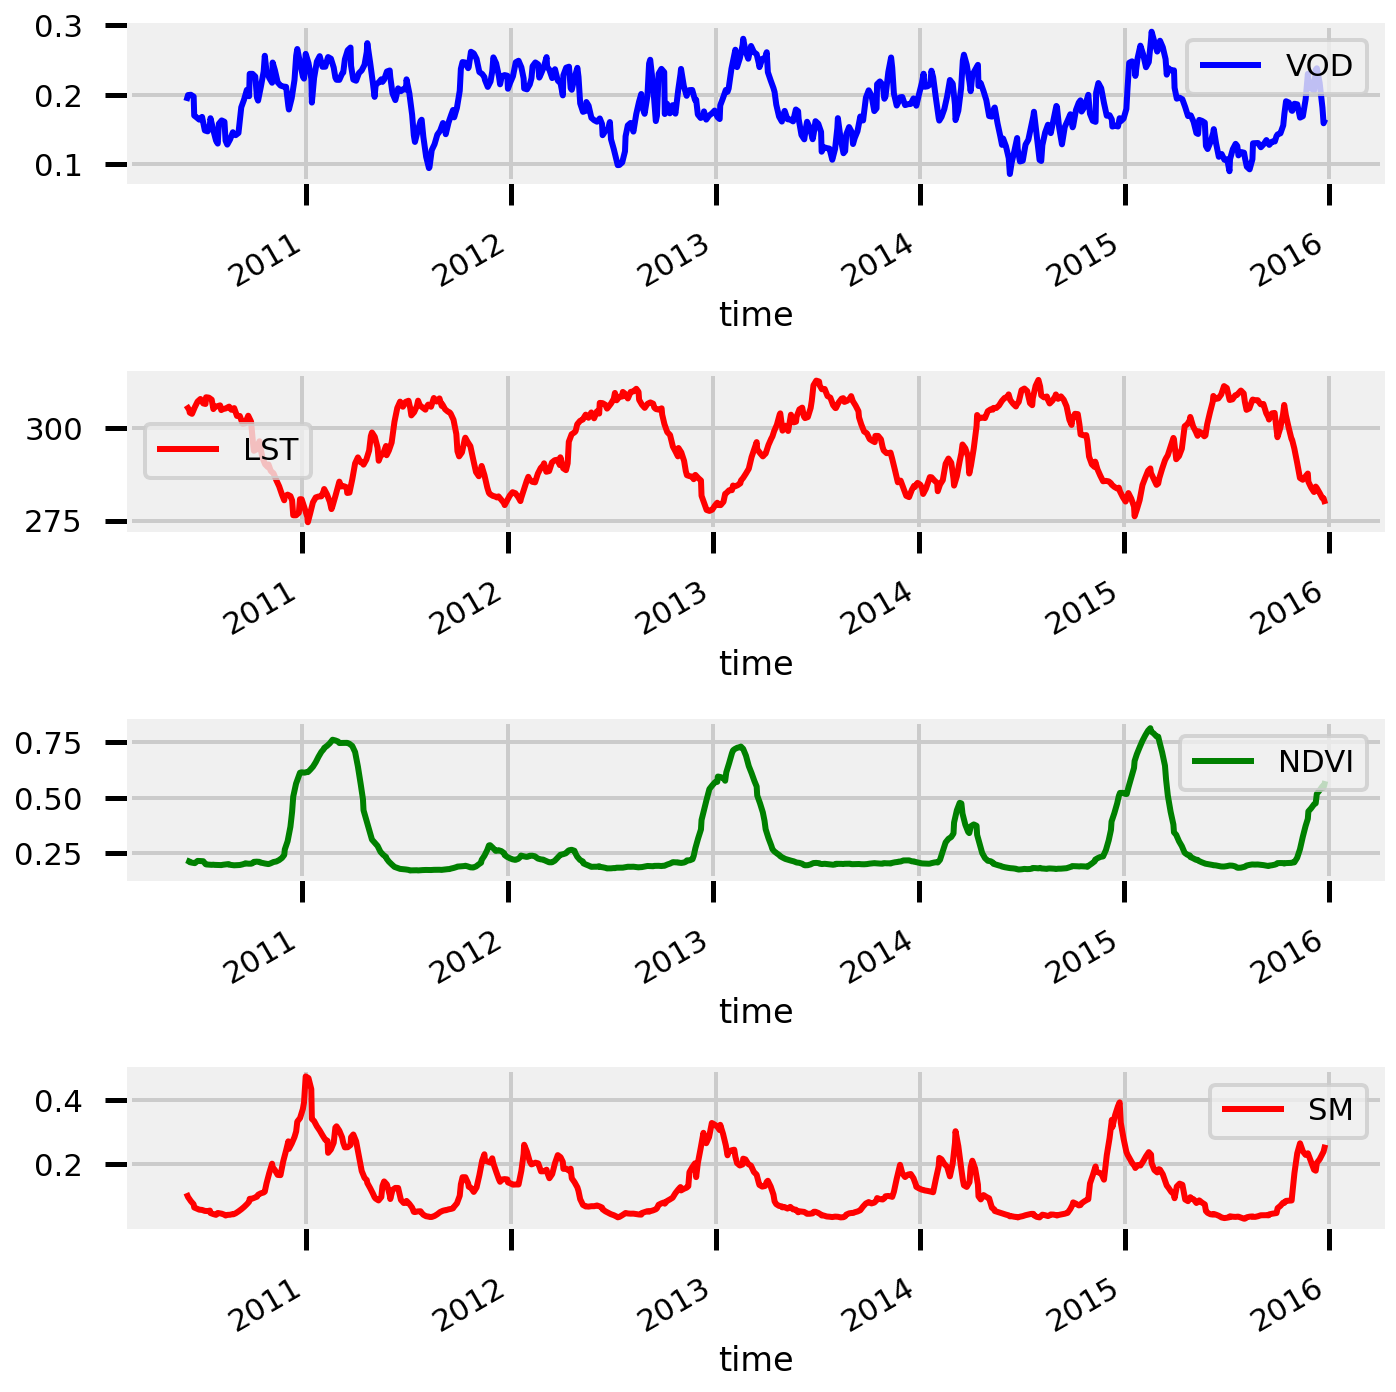

In [4]:
plot_ts(demo_pixel_interp_rolling)

#### Plot Anomalies

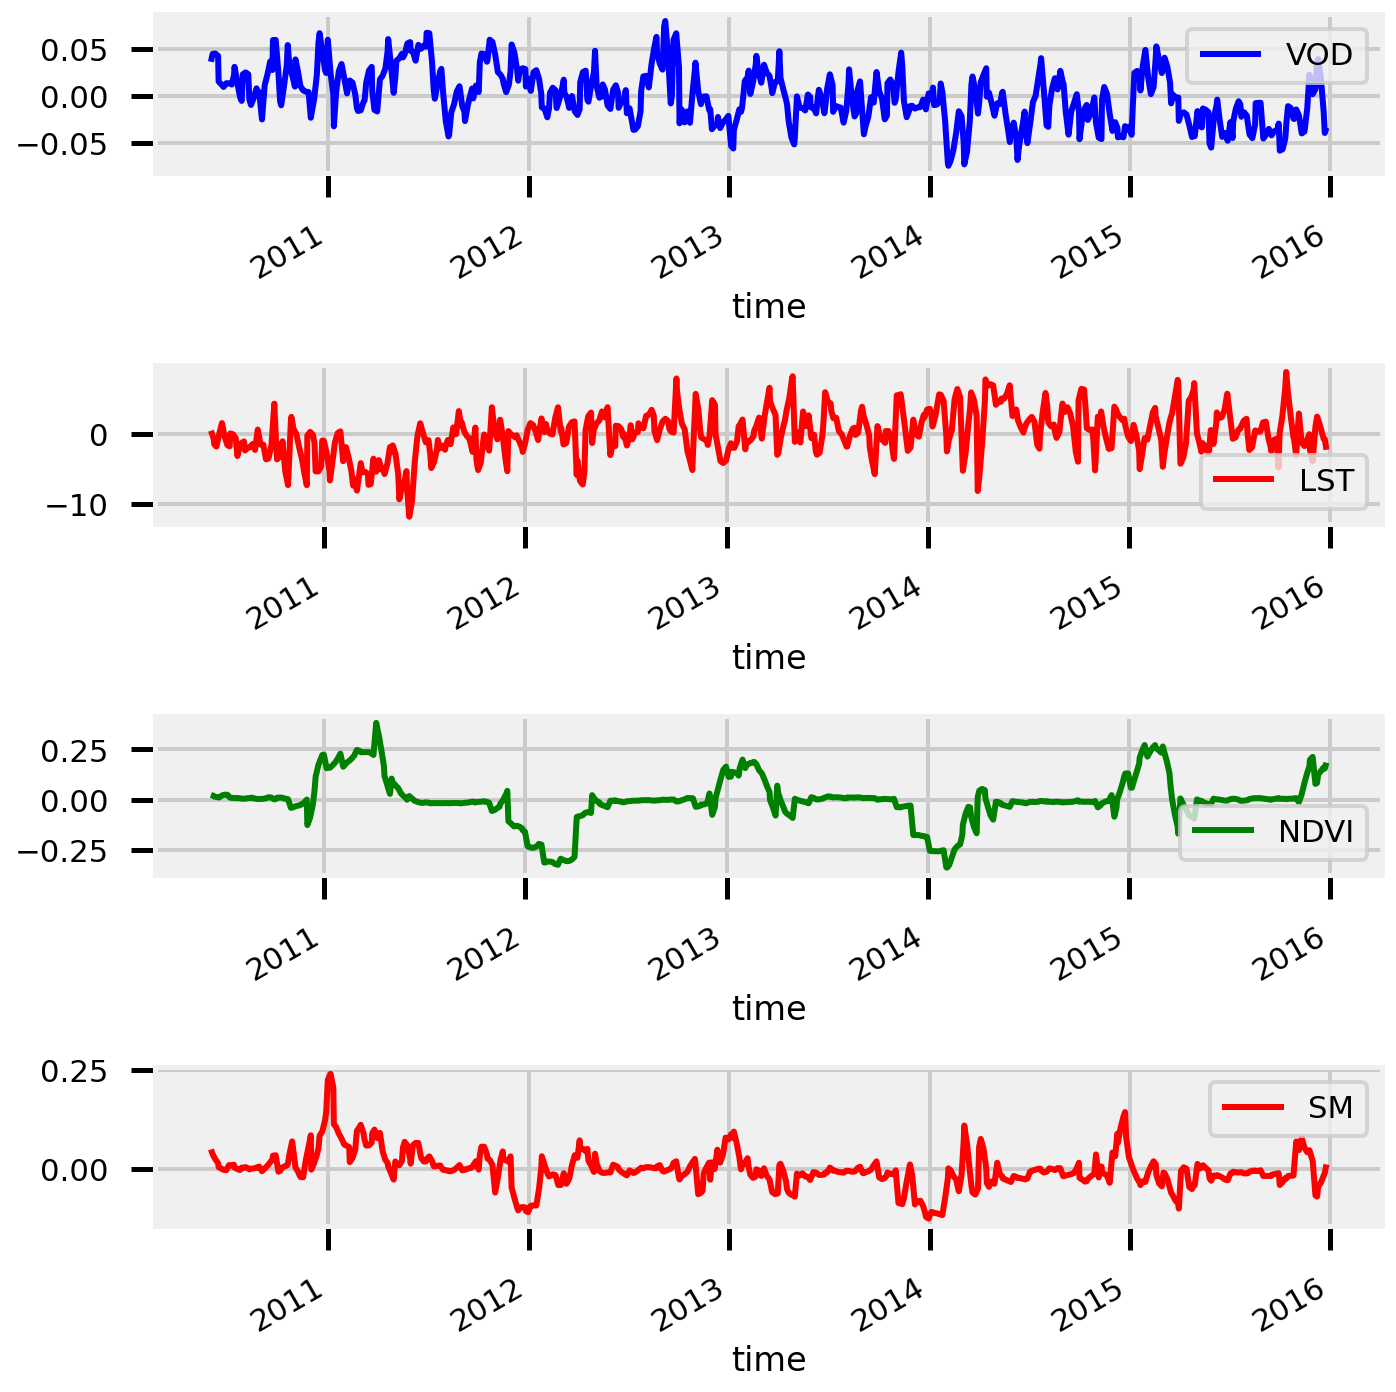

In [5]:
plot_ts(demo_pixel_anomalies)

## AutoCorrelation (Self)

In [6]:
def autocorrelation(x: np.ndarray, symmetric: bool=True) -> np.ndarray:
    """Computes the autocorrlation of a signal
    
    Parameters
    ----------
    x : np.ndarray
        the input array, shape=(n_samples,)
    symmetric : bool, default=True
        whether to return the symmetric or not
    
    Returns
    -------
    auto_corr : np.ndarray
        the autocorrelation, shape=(n_samples,) or
        shape=(n_samples/2,) if symmetric is True
    """
    
    # remove the sample mean
    x -= np.mean(x)
    
    # compute lags
    n_samples = x.shape[0]
    lags = compute_lags(x)
    
    # compute cross correlation
    auto_corr = np.correlate(x, x, mode="full")
    
    # normalize by the zero-lag value
    auto_corr /= auto_corr[n_samples - 1]
    
    if symmetric:
        return auto_corr[n_samples-1:], lags[n_samples-1:]
    else:
        return auto_corr, lags


def compute_lags(x):
    """compute the lags"""
    return np.arange(-x.shape[0] + 1, x.shape[0])

In [7]:
def plot_autocorr(ds, xlabel: str="Lag"):
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

    ds.VOD.plot(ax=ax[0,0], color="blue")
    ax[0,0].set(
        ylabel="Correlation Coefficient", title="VOD", 
        xticklabels=[], xlabel=""
    )

    ds.LST.plot(ax=ax[0,1], color="red")
    ax[0,1].set(
        ylabel="", title="Land Surface Temperature", 
        xticklabels=[], xlabel=""
    )

    ds.NDVI.plot(ax=ax[1,0], color="green")
    ax[1,0].set(
        xlabel=xlabel, ylabel="Correlation Coefficient", title="NDVI"
    )


    ds.SM.plot(ax=ax[1,1], color="orange")
    ax[1,1].set(
        xlabel=xlabel, ylabel="", title="Soil Moisture", 

    )


    plt.show()

    return None

In [8]:
# drop nans
demo_pixel_interp_rolling = demo_pixel_interp_rolling.dropna(dim="time")


autocorr_variables = {}

# compute the autocorrelation
for ivariable in ["LST", "VOD", "NDVI", "SM"]:
    
    # compute autocorrelation
    auto_corr, lags = autocorrelation(demo_pixel_interp_rolling[ivariable], False)
    
    autocorr_variables[f"{ivariable}_autocorr"] = auto_corr

### Plot

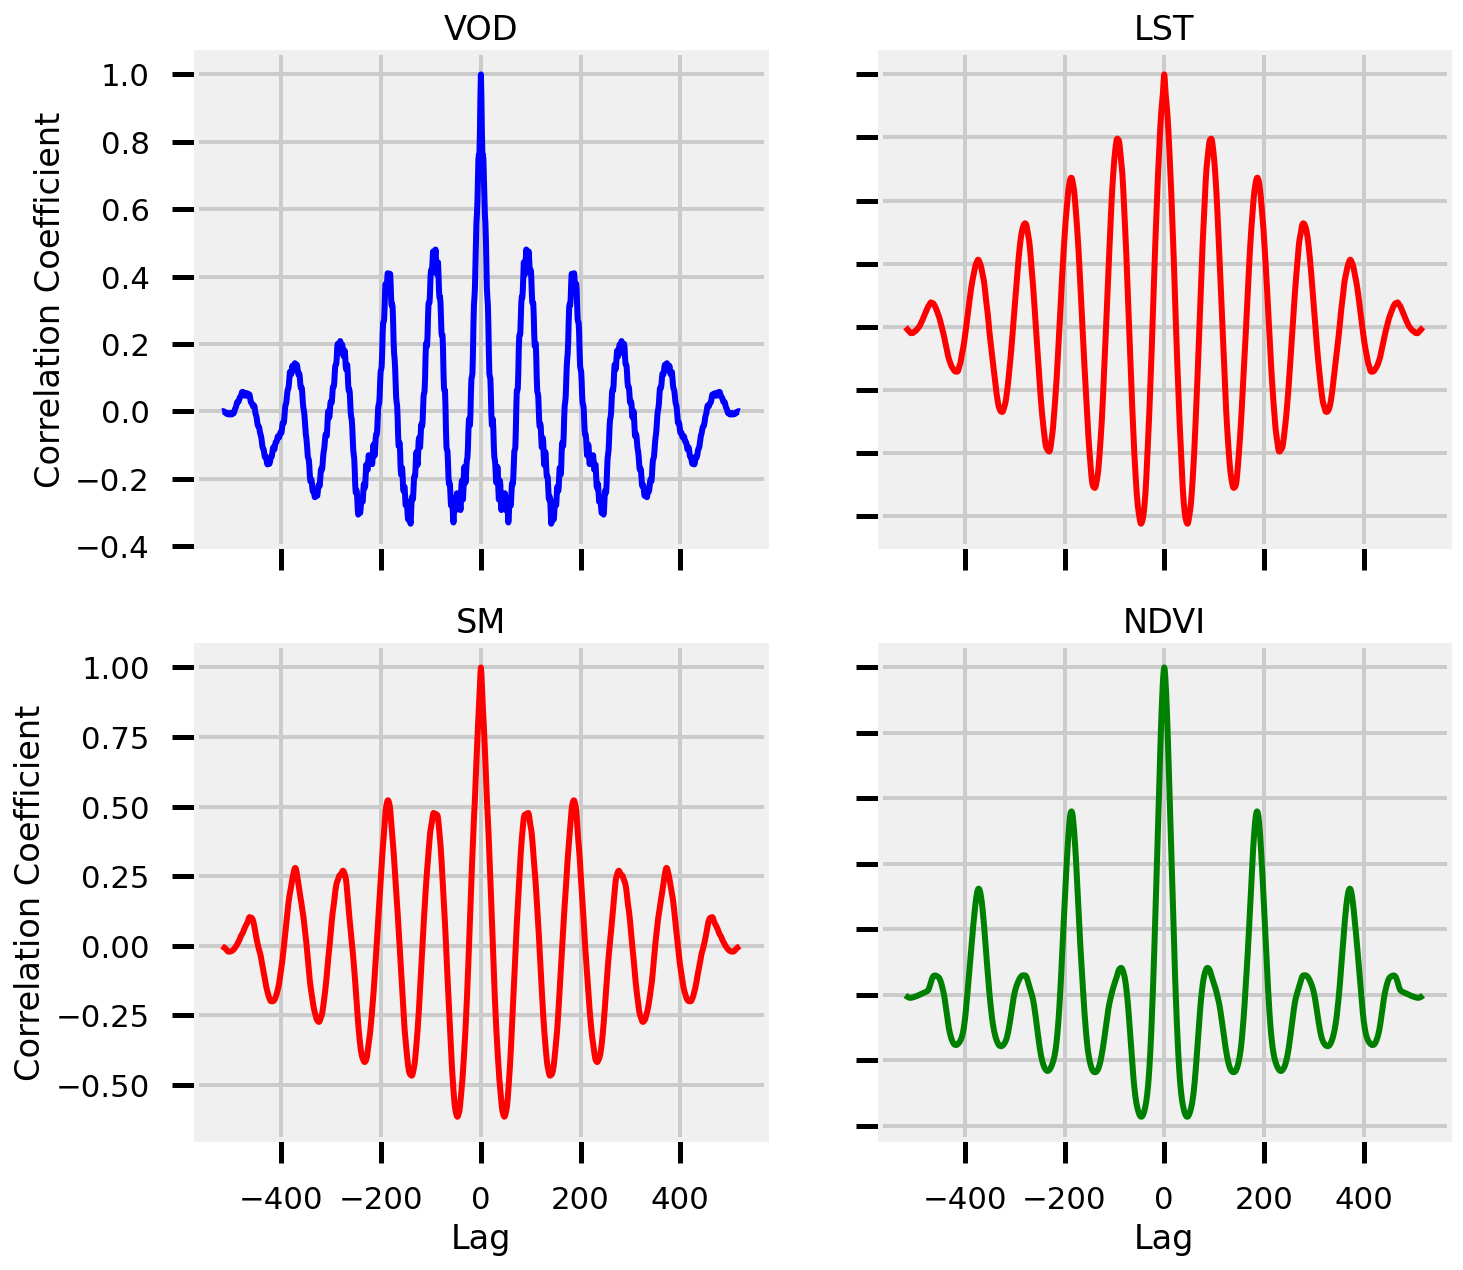

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

ax[0,0].plot(lags, autocorr_variables["VOD_autocorr"], "blue")
ax[0,0].set(
    ylabel="Correlation Coefficient", title="VOD", 
    xticklabels=[]
)

ax[0,1].plot(lags, autocorr_variables["LST_autocorr"], "red")
ax[0,1].set(
    ylabel="", title="LST", 
    xticklabels=[], yticklabels=[]
)

ax[1,0].plot(lags, autocorr_variables["SM_autocorr"], "red")
ax[1,0].set(
    xlabel="Lag", ylabel="Correlation Coefficient", title="SM"
)

ax[1,1].plot(lags, autocorr_variables["NDVI_autocorr"], "green")
ax[1,1].set(
    xlabel="Lag", ylabel="", title="NDVI", 
    yticklabels=[]
)

# ax.grid(True)
plt.show()

### Assume Symmetry

Because it is a time series, we can assume symmetry.

In [10]:
# drop nans
autocorr_variables = demo_pixel_interp_rolling.dropna(dim="time")


# small hack to make it a single output function
def body(x):
    ac, _ = autocorrelation(x, True)
    return ac

# compute autocorr for each of the variables
ds = autocorr_variables.map(body)

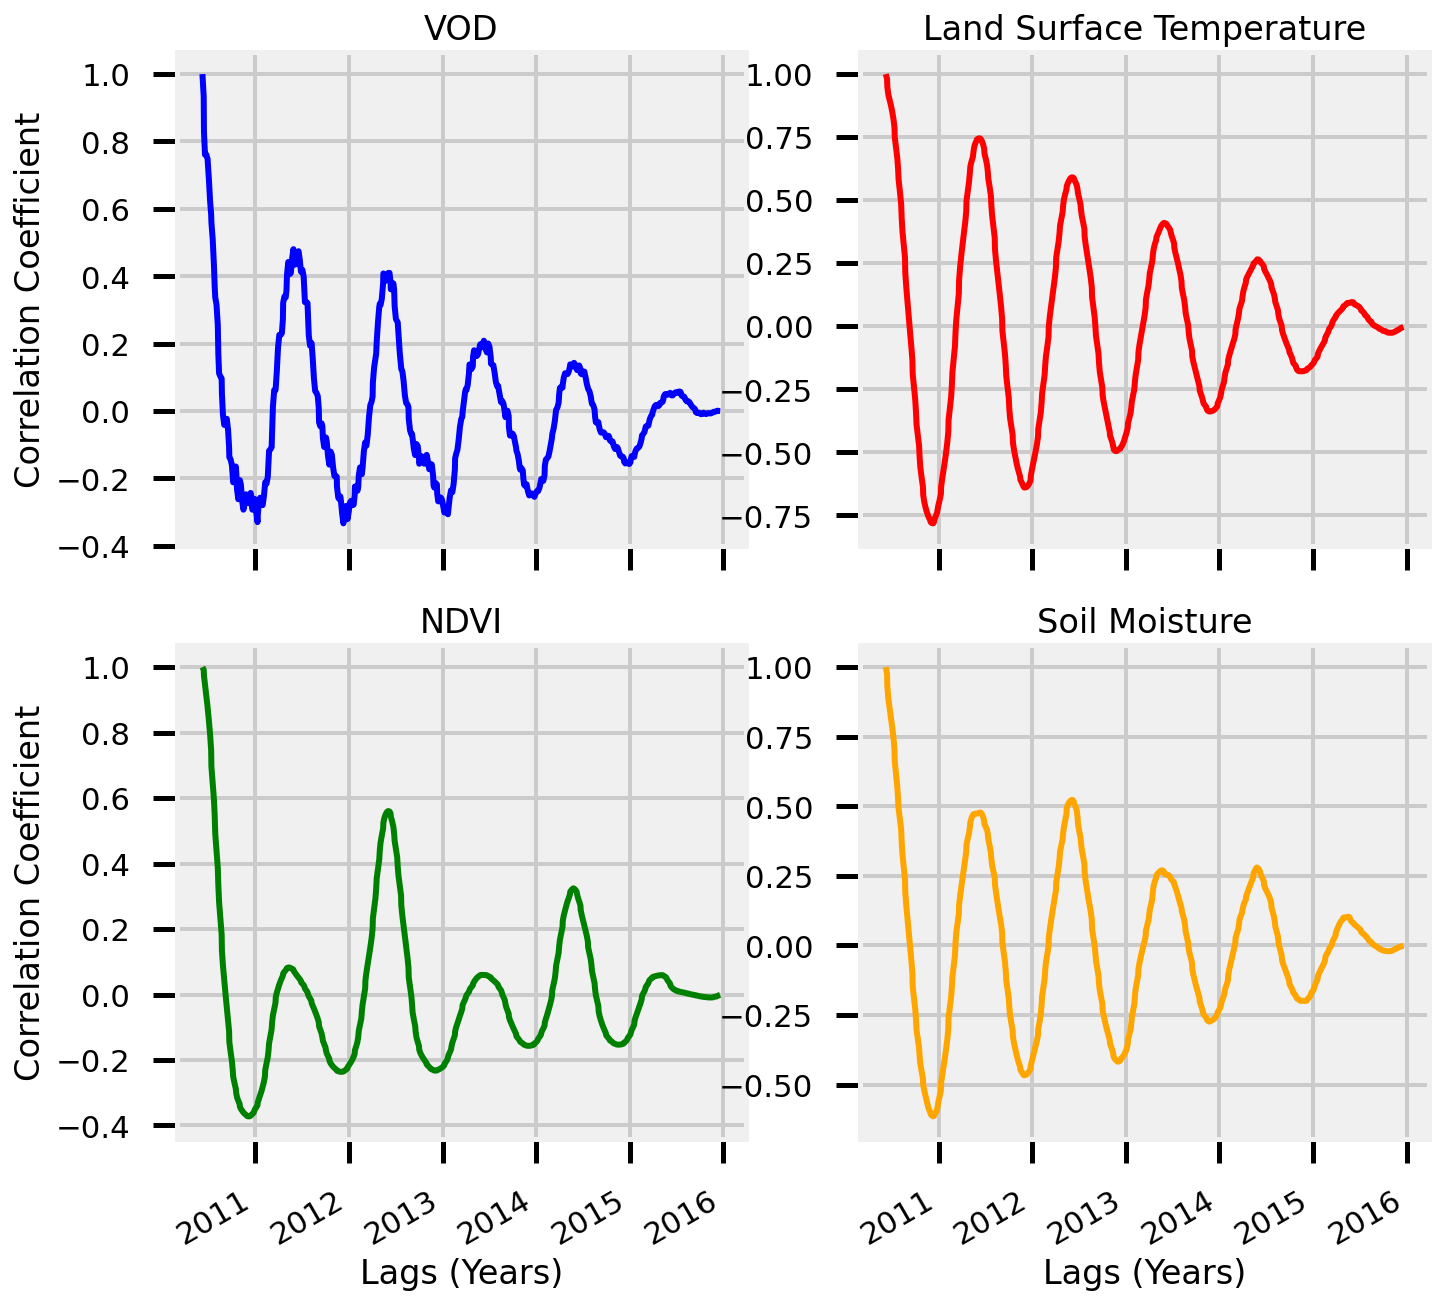

In [11]:
plot_autocorr(ds, "Lags (Years)")

### For a Year

In [12]:
from functools import partial

# drop nans
demo_pixel_interp_rolling = demo_pixel_interp_rolling.dropna(dim="time")

# copy the data array
autocorr_variables = demo_pixel_interp_rolling.copy()


# groupby year
autocorr_variables = autocorr_variables.groupby("time.year")


# small hack to make it a single output function
def body(x):
    ac, _ = autocorrelation(x, True)
    return ac

datasets = []

# loop through different years
for iyear, i_dataset in autocorr_variables:
        
    # map each of the autocorrelations over each of the variables 
    i_dataset = i_dataset.map(body)
    
    # append the dataset to the list
    datasets.append(i_dataset)  

# merge the datasets
ds = xr.merge(datasets)

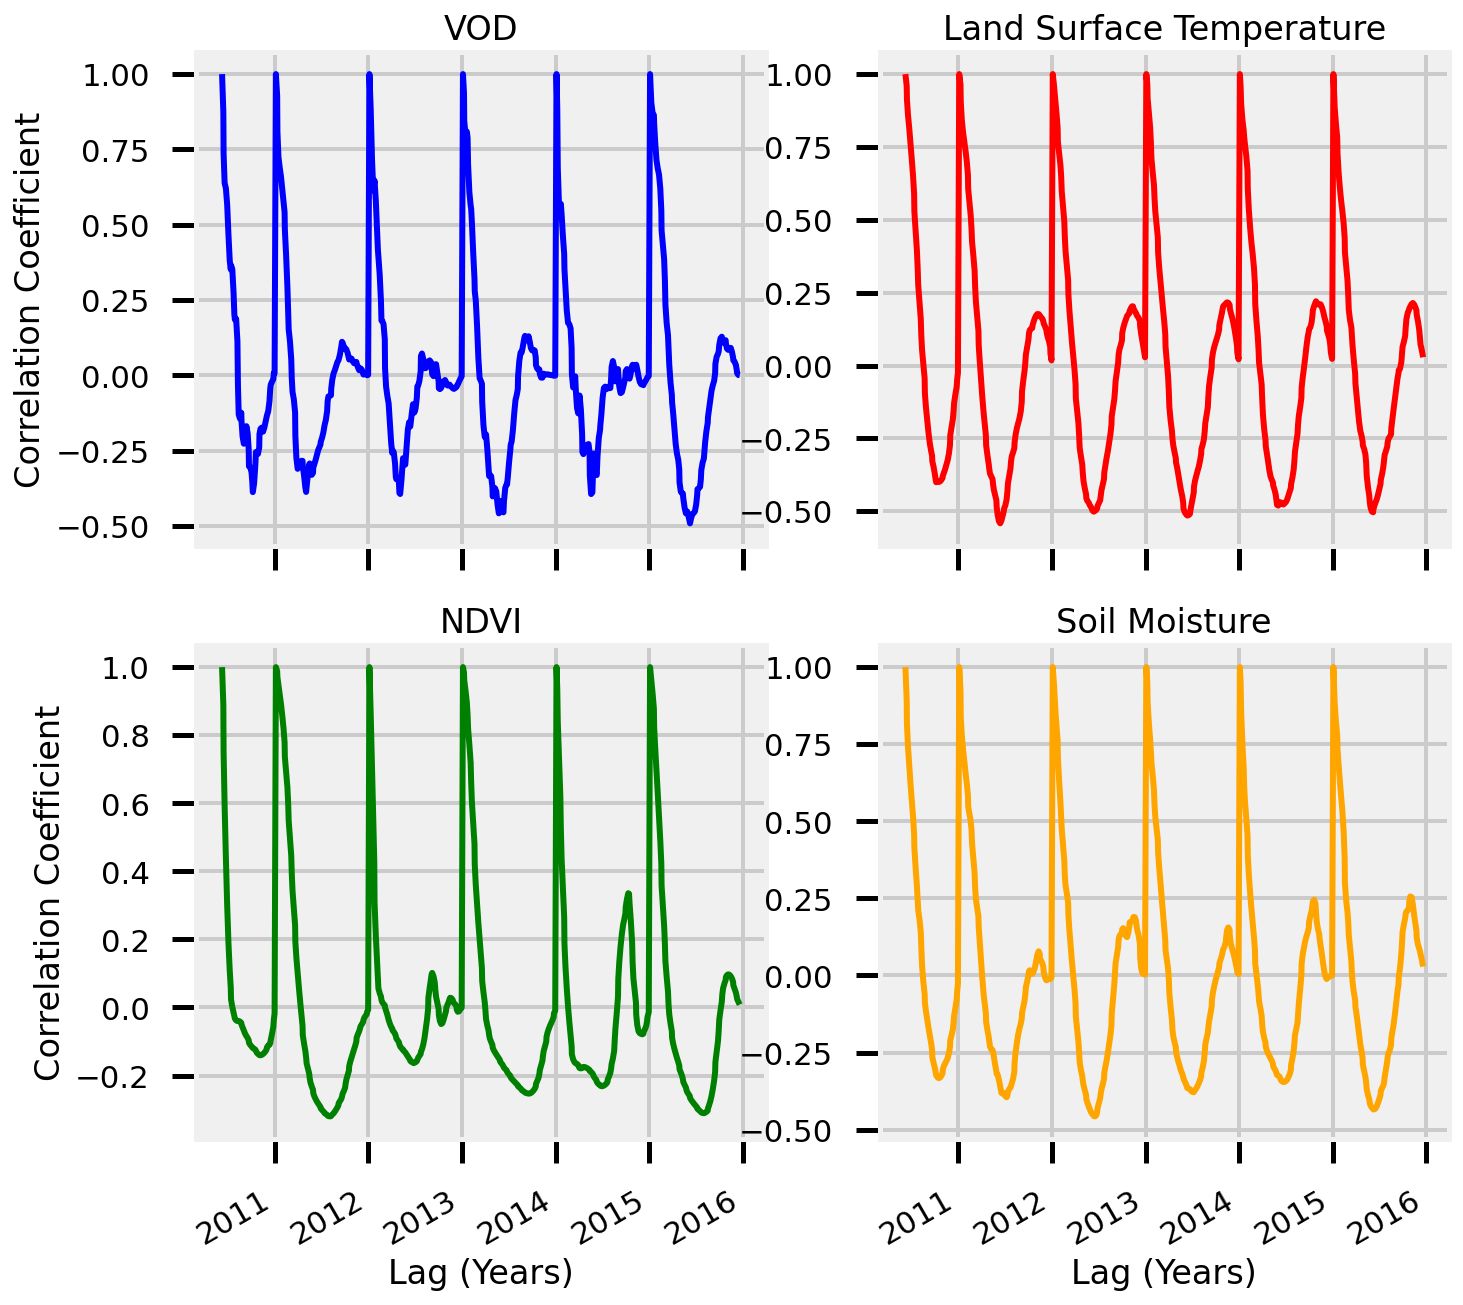

In [13]:
plot_autocorr(ds, "Lag (Years)")

### Average Per Year - Per Month

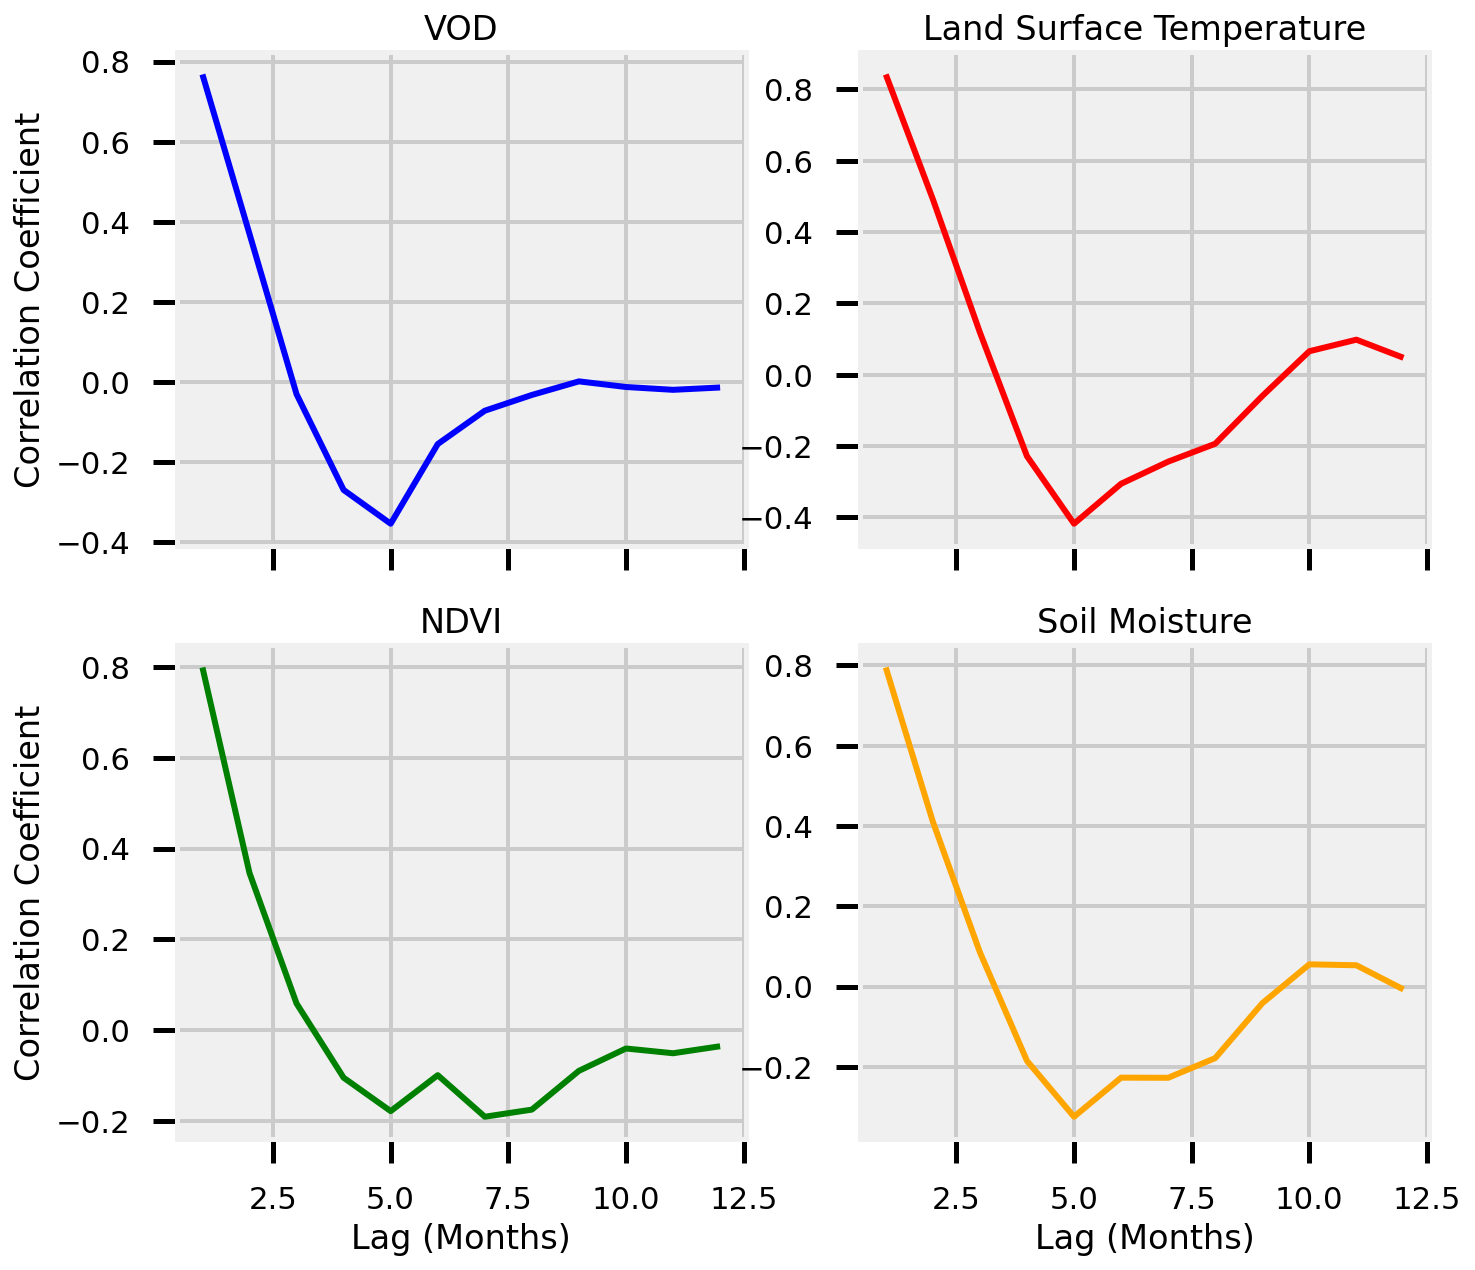

In [14]:
plot_autocorr(ds.groupby("time.month").mean(), "Lag (Months)")

#### Days within 1 Month  Autocorrelation

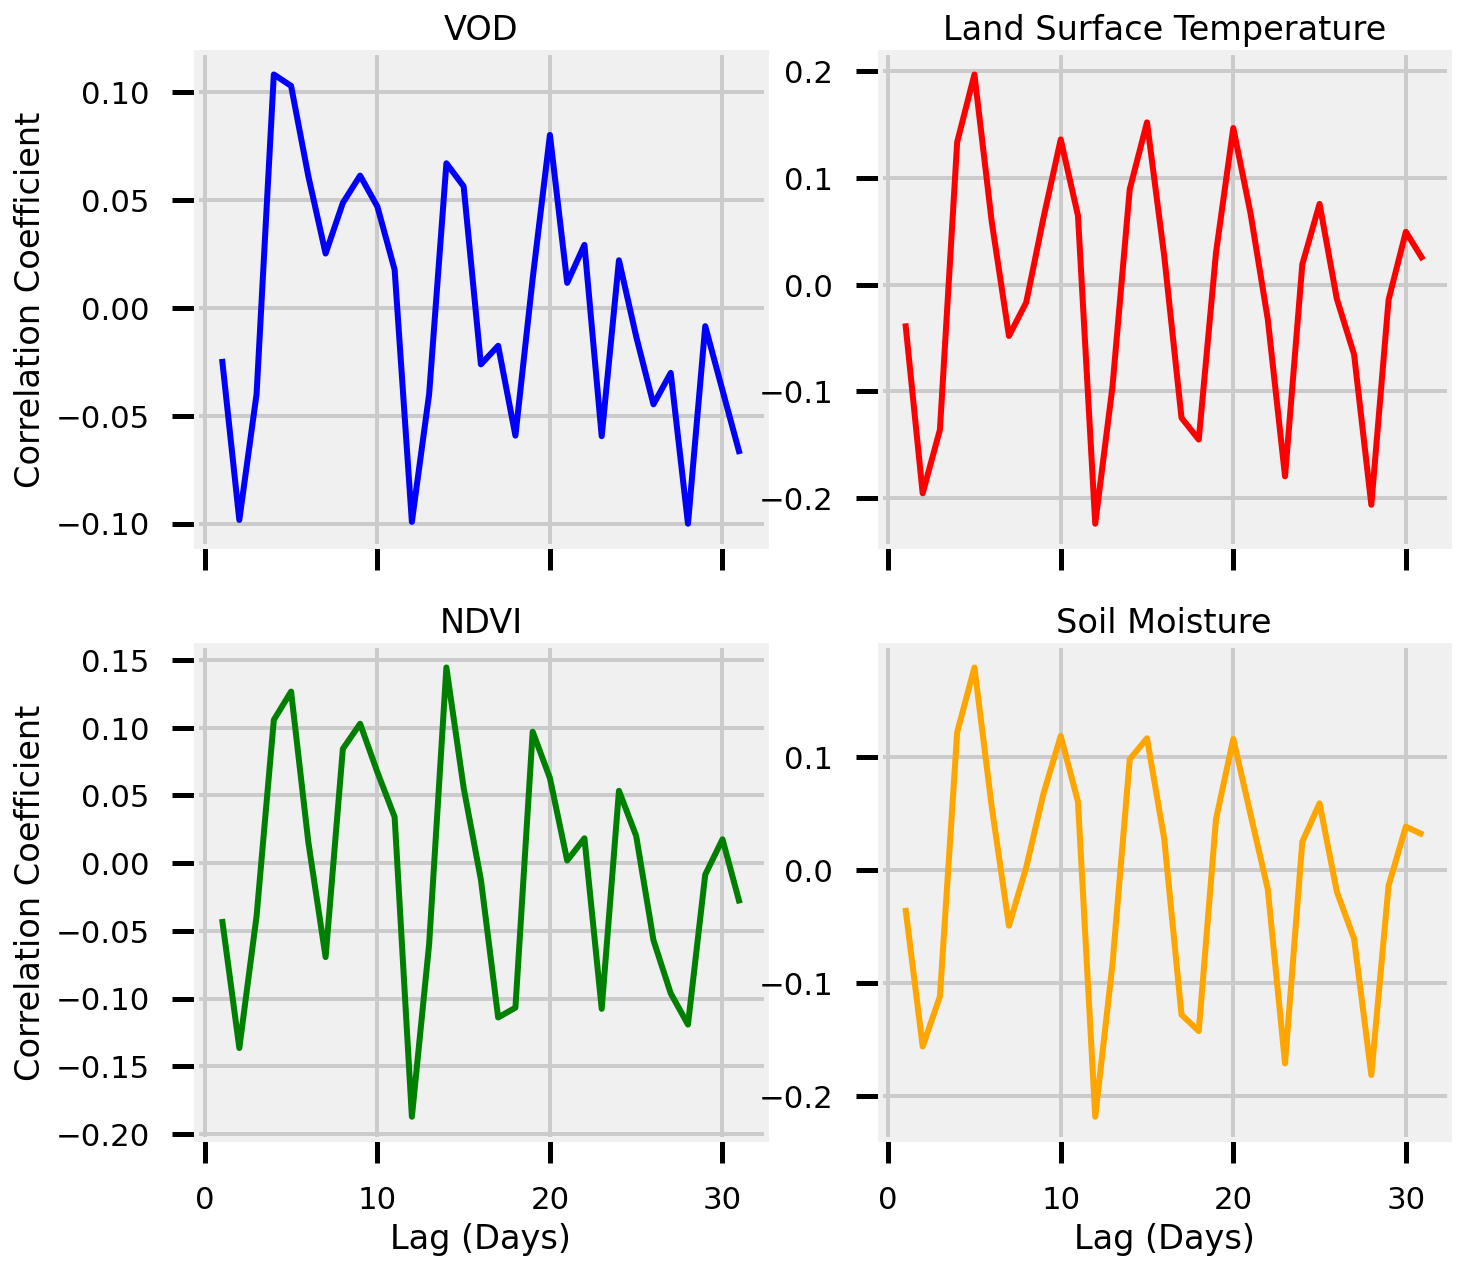

In [15]:
plot_autocorr(ds.groupby("time.day").mean(), "Lag (Days)")